In [1]:
from coco import create_coco_dataloaders
from model import MINDObjectDetector
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import generalized_box_iou, box_iou
from scipy.optimize import linear_sum_assignment

/home/thomas/miniforge3/envs/mind/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader, test_loader = create_coco_dataloaders()

model = MINDObjectDetector(
    input_size=224,
    num_heads=12,
    dynamic_categories=91,
    rank=32,
    mode="supervised",
    adaptable_moe=True,
    initial_vigilance=0.75,
    vigilance_increment=0.05,
    modality="object_detection",
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



loading annotations into memory...
Done (t=13.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!

Added 90 new experts, total now: 92
Feature map dimensions: [128, 256, 512, 1024]


MINDObjectDetector(
  (art_module): FuzzyARTMAP()
  (gating_network): GatingNetwork(
    (fc): Linear(in_features=768, out_features=92, bias=True)
  )
  (moe_adapters): MixtureOfAdapters(
    (adapters): ModuleList(
      (0-91): 92 x LoRALayer(
        (down): Linear(in_features=768, out_features=32, bias=False)
        (up): Linear(in_features=32, out_features=768, bias=False)
      )
    )
  )
  (backbone): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_feat

In [3]:
model_path = "checkpoint.pth"
import os 
if os.path.exists(model_path):
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint["model"])
    except Exception as e:
        print(f"Failed to load checkpoint: {e}")
        exit(1)
else:
    print("Starting training from scratch.")


/tmp/ipykernel_266749/207096646.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

# List of COCO class names, 80 classes + 1 background
# Make sure these match the ordering used by your model
COCO_CLASSES_91 = [
    "N/A",           # 0
    "person",        # 1
    "bicycle",       # 2
    "car",           # 3
    "motorcycle",    # 4
    "airplane",      # 5
    "bus",           # 6
    "train",         # 7
    "truck",         # 8
    "boat",          # 9
    "traffic light", # 10
    "fire hydrant",  # 11
    "N/A",           # 12
    "stop sign",     # 13
    "parking meter", # 14
    "bench",         # 15
    "bird",          # 16
    "cat",           # 17
    "dog",           # 18
    "horse",         # 19
    "sheep",         # 20
    "cow",           # 21
    "elephant",      # 22
    "bear",          # 23
    "zebra",         # 24
    "giraffe",       # 25
    "N/A",           # 26
    "backpack",      # 27
    "umbrella",      # 28
    "N/A",           # 29
    "N/A",           # 30
    "handbag",       # 31
    "tie",           # 32
    "suitcase",      # 33
    "frisbee",       # 34
    "skis",          # 35
    "snowboard",     # 36
    "sports ball",   # 37
    "kite",          # 38
    "baseball bat",  # 39
    "baseball glove",# 40
    "skateboard",    # 41
    "surfboard",     # 42
    "tennis racket", # 43
    "bottle",        # 44
    "N/A",           # 45
    "wine glass",    # 46
    "cup",           # 47
    "fork",          # 48
    "knife",         # 49
    "spoon",         # 50
    "bowl",          # 51
    "banana",        # 52
    "apple",         # 53
    "sandwich",      # 54
    "orange",        # 55
    "broccoli",      # 56
    "carrot",        # 57
    "hot dog",       # 58
    "pizza",         # 59
    "donut",         # 60
    "cake",          # 61
    "chair",         # 62
    "couch",         # 63
    "potted plant",  # 64
    "bed",           # 65
    "N/A",           # 66
    "dining table",  # 67
    "N/A",           # 68
    "N/A",           # 69
    "toilet",        # 70
    "N/A",           # 71
    "tv",            # 72
    "laptop",        # 73
    "mouse",         # 74
    "remote",        # 75
    "keyboard",      # 76
    "cell phone",    # 77
    "microwave",     # 78
    "oven",          # 79
    "toaster",       # 80
    "sink",          # 81
    "refrigerator",  # 82
    "N/A",           # 83
    "book",          # 84
    "clock",         # 85
    "vase",          # 86
    "scissors",      # 87
    "teddy bear",    # 88
    "hair drier",    # 89
    "toothbrush"     # 90
]


In [20]:
device = next(model.parameters()).device  # automatically detects if model is on cuda/cpu

for nested, targets in train_loader:
    tensors, masks = nested.decompose()
    tensors = tensors.to(device)
    masks = masks.to(device)
    outputs = model(tensors)
    break


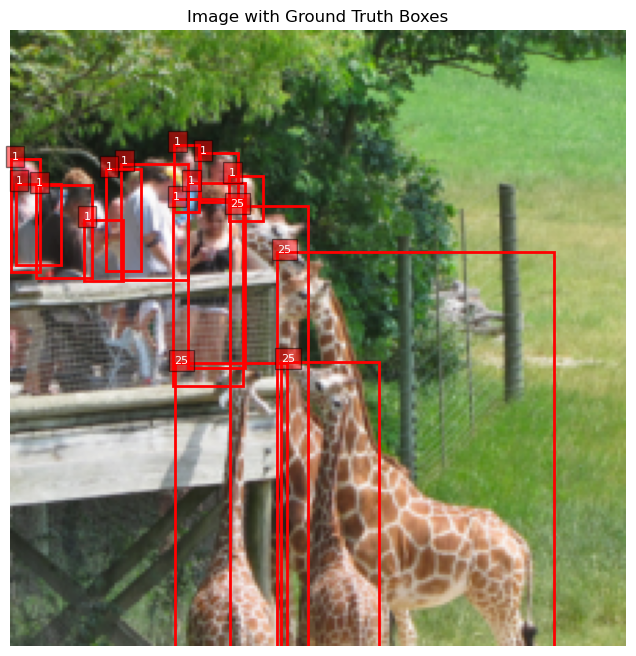

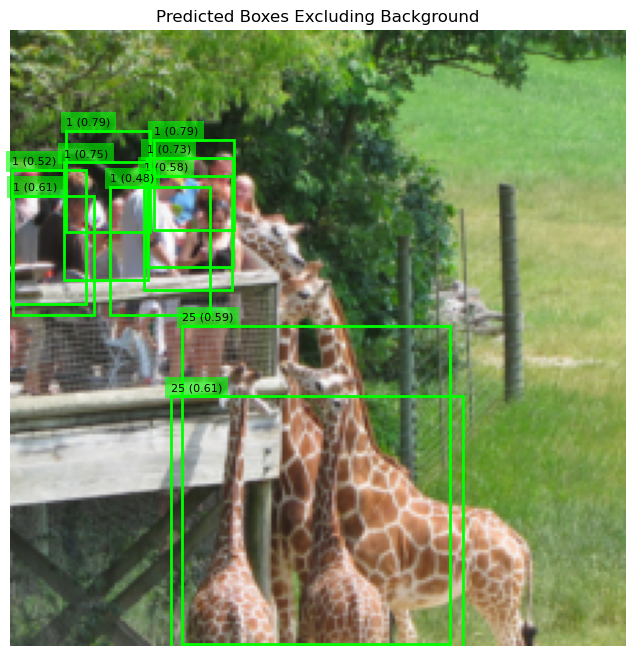

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# We'll visualize the first image in the batch
boxes = targets[0]["boxes"]  # [N, 4]
labels = targets[0]["labels"]
H, W = targets[0]["size"]  # assumed to be tensor([224, 224])

# Convert image to numpy format for plotting
def denormalize_image(img_tensor, mean, std):
    """
    Undo normalization on a tensor image.
    Expects shape [3, H, W] and values in normalized space.
    """
    mean = torch.tensor(mean).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(img_tensor.device)
    return (img_tensor * std) + mean

# COCO-style normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Get image and denormalize
img = tensors[0]  # [3, H, W]
img_denorm = denormalize_image(img, mean, std).clamp(0, 1)

# Convert to PIL image for display
img_np = TF.to_pil_image(img_denorm.cpu())

# Convert boxes from [cx, cy, w, h] to [x0, y0, x1, y1]
boxes_xyxy = boxes.clone()
boxes_xyxy[:, 0] = (boxes[:, 0] - boxes[:, 2] / 2) * W
boxes_xyxy[:, 1] = (boxes[:, 1] - boxes[:, 3] / 2) * H
boxes_xyxy[:, 2] = (boxes[:, 0] + boxes[:, 2] / 2) * W
boxes_xyxy[:, 3] = (boxes[:, 1] + boxes[:, 3] / 2) * H

# Plotting
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
ax = plt.gca()

for box, label in zip(boxes_xyxy, labels):
    x0, y0, x1, y1 = box.tolist()
    rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                         fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(x0, y0, str(label.item()), color='white', fontsize=8,
            bbox=dict(facecolor='red', alpha=0.5))

plt.title("Image with Ground Truth Boxes")
plt.axis("off")
plt.show()


pred_logits = outputs["pred_logits"][0]     # [num_queries, num_classes + 1]
pred_boxes = outputs["pred_boxes"][0]       # [num_queries, 4]
img = tensors[0]  # [3, H, W]

img_tensor=img
pred_logits=pred_logits
pred_boxes=pred_boxes

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def denormalize_image(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(img_tensor.device)
    return (img_tensor * std) + mean

# === Get image and predictions ===
img = tensors[0]  # [3, H, W]
img_denorm = denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).clamp(0, 1)
img_np = TF.to_pil_image(img_denorm.cpu())

pred_logits = outputs["pred_logits"][0]   # [num_queries, num_classes + 1]
pred_boxes = outputs["pred_boxes"][0]     # [num_queries, 4]

# === Get most confident class and score for each prediction ===
pred_probs = pred_logits.softmax(-1)                # [num_queries, num_classes + 1]
scores, labels = pred_probs.max(-1)                 # max score and its index (including background)

# === Filter: not background and above confidence threshold ===
background_class = pred_logits.shape[-1] - 1
conf_thresh = 0

keep = (labels != background_class) & (scores > conf_thresh)

boxes_cxcywh = pred_boxes[keep]
labels = labels[keep]
scores = scores[keep]

# === Convert boxes to [x0, y0, x1, y1] in image coordinates ===
img_w, img_h = img_np.size
boxes_xyxy = boxes_cxcywh.clone()
boxes_xyxy[:, 0] = (boxes_cxcywh[:, 0] - boxes_cxcywh[:, 2] / 2) * img_w  # x0
boxes_xyxy[:, 1] = (boxes_cxcywh[:, 1] - boxes_cxcywh[:, 3] / 2) * img_h  # y0
boxes_xyxy[:, 2] = (boxes_cxcywh[:, 0] + boxes_cxcywh[:, 2] / 2) * img_w  # x1
boxes_xyxy[:, 3] = (boxes_cxcywh[:, 1] + boxes_cxcywh[:, 3] / 2) * img_h  # y1

# === Plot ===
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
ax = plt.gca()

for box, label, score in zip(boxes_xyxy, labels, scores):
    x0, y0, x1, y1 = box.tolist()
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                               fill=False, edgecolor='lime', linewidth=2))
    ax.text(x0, y0 - 2,
            f"{label.item()} ({score:.2f})",
            fontsize=8,
            color='black',
            bbox=dict(facecolor='lime', alpha=0.6, edgecolor='none'))

plt.title("Predicted Boxes Excluding Background")
plt.axis("off")
plt.show()

In [7]:

pred_logits = outputs["pred_logits"][0]     # [num_queries, num_classes + 1]
pred_boxes = outputs["pred_boxes"][0]       # [num_queries, 4]
img = tensors[0]  # [3, H, W]

In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

# List of COCO class names, 80 classes + 1 background
# Make sure these match the ordering used by your model
COCO_CLASSES_91 = [
    "N/A",           # 0
    "person",        # 1
    "bicycle",       # 2
    "car",           # 3
    "motorcycle",    # 4
    "airplane",      # 5
    "bus",           # 6
    "train",         # 7
    "truck",         # 8
    "boat",          # 9
    "traffic light", # 10
    "fire hydrant",  # 11
    "N/A",           # 12
    "stop sign",     # 13
    "parking meter", # 14
    "bench",         # 15
    "bird",          # 16
    "cat",           # 17
    "dog",           # 18
    "horse",         # 19
    "sheep",         # 20
    "cow",           # 21
    "elephant",      # 22
    "bear",          # 23
    "zebra",         # 24
    "giraffe",       # 25
    "N/A",           # 26
    "backpack",      # 27
    "umbrella",      # 28
    "N/A",           # 29
    "N/A",           # 30
    "handbag",       # 31
    "tie",           # 32
    "suitcase",      # 33
    "frisbee",       # 34
    "skis",          # 35
    "snowboard",     # 36
    "sports ball",   # 37
    "kite",          # 38
    "baseball bat",  # 39
    "baseball glove",# 40
    "skateboard",    # 41
    "surfboard",     # 42
    "tennis racket", # 43
    "bottle",        # 44
    "N/A",           # 45
    "wine glass",    # 46
    "cup",           # 47
    "fork",          # 48
    "knife",         # 49
    "spoon",         # 50
    "bowl",          # 51
    "banana",        # 52
    "apple",         # 53
    "sandwich",      # 54
    "orange",        # 55
    "broccoli",      # 56
    "carrot",        # 57
    "hot dog",       # 58
    "pizza",         # 59
    "donut",         # 60
    "cake",          # 61
    "chair",         # 62
    "couch",         # 63
    "potted plant",  # 64
    "bed",           # 65
    "N/A",           # 66
    "dining table",  # 67
    "N/A",           # 68
    "N/A",           # 69
    "toilet",        # 70
    "N/A",           # 71
    "tv",            # 72
    "laptop",        # 73
    "mouse",         # 74
    "remote",        # 75
    "keyboard",      # 76
    "cell phone",    # 77
    "microwave",     # 78
    "oven",          # 79
    "toaster",       # 80
    "sink",          # 81
    "refrigerator",  # 82
    "N/A",           # 83
    "book",          # 84
    "clock",         # 85
    "vase",          # 86
    "scissors",      # 87
    "teddy bear",    # 88
    "hair drier",    # 89
    "toothbrush"     # 90
]

img_tensor=img
pred_logits=pred_logits
pred_boxes=pred_boxes
threshold=0.1


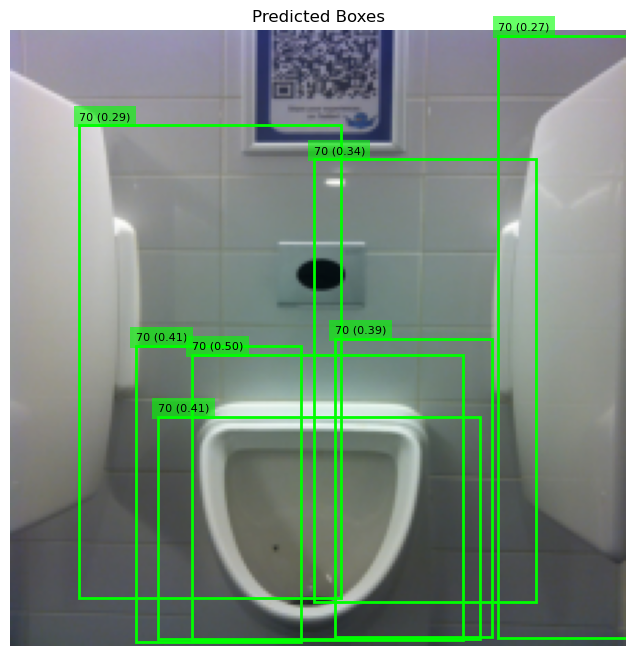

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def denormalize_image(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(img_tensor.device)
    return (img_tensor * std) + mean

# === Get image and predictions ===
img = tensors[0]  # [3, H, W]
img_denorm = denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).clamp(0, 1)
img_np = TF.to_pil_image(img_denorm.cpu())

pred_logits = outputs["pred_logits"][0]   # [num_queries, num_classes (+1)]
pred_boxes = outputs["pred_boxes"][0]     # [num_queries, 4] in [cx, cy, w, h] normalized
pred_scores = pred_logits.softmax(-1)     # [num_queries, num_classes]
scores, labels = pred_scores[:, :-1].max(-1)  # Exclude background class

# === Filter by confidence threshold ===
conf_thresh = 0.25
keep = scores > conf_thresh

boxes_cxcywh = pred_boxes[keep]
labels = labels[keep]
scores = scores[keep]

# === Convert to [x0, y0, x1, y1] in image coordinates ===
img_w, img_h = img_np.size
boxes_xyxy = boxes_cxcywh.clone()
boxes_xyxy[:, 0] = (boxes_cxcywh[:, 0] - boxes_cxcywh[:, 2] / 2) * img_w  # x0
boxes_xyxy[:, 1] = (boxes_cxcywh[:, 1] - boxes_cxcywh[:, 3] / 2) * img_h  # y0
boxes_xyxy[:, 2] = (boxes_cxcywh[:, 0] + boxes_cxcywh[:, 2] / 2) * img_w  # x1
boxes_xyxy[:, 3] = (boxes_cxcywh[:, 1] + boxes_cxcywh[:, 3] / 2) * img_h  # y1

# === Plot ===
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
ax = plt.gca()

for box, label, score in zip(boxes_xyxy, labels, scores):
    x0, y0, x1, y1 = box.tolist()
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                               fill=False, edgecolor='lime', linewidth=2))
    ax.text(x0, y0 - 2,
            f"{label.item()} ({score:.2f})",
            fontsize=8,
            color='black',
            bbox=dict(facecolor='lime', alpha=0.6, edgecolor='none'))

plt.title("Predicted Boxes")
plt.axis("off")
plt.show()


In [10]:
for nested, targets in test_loader:
    tensors, masks = nested.decompose()
    tensors = tensors.to(device)
    masks = masks.to(device)
    outputs = model(tensors)
    break
print(tensors.shape)
print(masks.shape)
print(outputs["pred_logits"].shape)
print(outputs["pred_boxes"].shape)


# torch.Size([2, 3, 224, 224])
# torch.Size([2, 224, 224])
# torch.Size([2, 196, 92])
# torch.Size([2, 196, 4])

torch.Size([2, 3, 224, 224])
torch.Size([2, 224, 224])
torch.Size([2, 100, 92])
torch.Size([2, 100, 4])


In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

def prepare_predictions(outputs, conf_threshold=0.05, top_k=100):
    pred_boxes = outputs["pred_boxes"].cpu()               # [B, N, 4]
    pred_logits = outputs["pred_logits"].softmax(-1)[..., :-1].cpu() # [B, N, C+1]

    batch = []
    for boxes, logits in zip(pred_boxes, pred_logits):
        scores, labels = logits.max(dim=-1) 

        # Filter out predictions below confidence threshold
        keep = scores > conf_threshold
        keep_indices = keep.nonzero(as_tuple=False).flatten()

        # If nothing passes the threshold, add empty prediction
        if keep_indices.numel() == 0:
            batch.append({
                "boxes": torch.empty((0, 4)),
                "scores": torch.empty((0,)),
                "labels": torch.empty((0,), dtype=torch.int64),
            })
            continue

        boxes = boxes[keep_indices]
        labels = logits[keep_indices].argmax(dim=-1)
        scores = scores[keep_indices]

        # Keep top_k most confident predictions
        if boxes.size(0) > top_k:
            topk_scores, topk_indices = scores.topk(top_k)
            boxes = boxes[topk_indices]
            labels = labels[topk_indices]
            scores = topk_scores

        batch.append({
            "boxes": boxes,
            "scores": scores,
            "labels": labels,
        })

    return batch

def prepare_targets(targets):
    batch = []
    for t in targets:
        batch.append({
            "boxes": t["boxes"].cpu(),
            "labels": t["labels"].cpu(),
        })
    return batch

# Evaluation loop with tqdm
model.eval()
with torch.no_grad():
    for nested, targets in tqdm(test_loader, desc="Evaluating", leave=False):
        tensors, masks = nested.decompose()
        tensors = tensors.to(device)
        masks = masks.to(device)

        outputs = model(tensors)

        preds = prepare_predictions(outputs)
        gts = prepare_targets(targets)

        metric.update(preds, gts)

# Final mAP result
final_result = metric.compute()
print("\nFinal mAP Results:")
for k, v in final_result.items():
    print(f"{k}: {v:.4f}")


Evaluating:   0%|          | 0/2500 [00:00<?, ?it/s]


Final mAP Results:
map: 0.0026
map_50: 0.0062
map_75: 0.0017
map_small: 0.0026
map_medium: -1.0000
map_large: -1.0000
mar_1: 0.0136
mar_10: 0.0267
mar_100: 0.0278
mar_small: 0.0278
mar_medium: -1.0000
mar_large: -1.0000


TypeError: unsupported format string passed to Tensor.__format__

In [ ]:
preds

[{'boxes': tensor([], size=(0, 4)),
  'scores': tensor([]),
  'labels': tensor([], dtype=torch.int64)},
 {'boxes': tensor([], size=(0, 4)),
  'scores': tensor([]),
  'labels': tensor([], dtype=torch.int64)}]